<a href="https://colab.research.google.com/github/deeshlby/instructional_resources/blob/main/project_notebook_jt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Installing and Importing libraries

In [1]:
!pip install pydicom python-gdcm pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg ultralytics

In [2]:
!pip install albumentations

In [3]:
!pip install timm

In [4]:
import pydicom
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageStat
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops
from ultralytics import YOLO
import cv2
import albumentations as A
import torch
import timm
from timm.models import create_model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

In [5]:
# Load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
cd /content/drive/MyDrive/RSNA_BreastCancer/

/content/drive/MyDrive/RSNA_BreastCancer


In [ ]:
# Intializing a data path

In [7]:
data_path = '/content/drive/MyDrive/RSNA_BreastCancer/'

In [9]:
# Load metadata
train_metadata = pd.read_csv(data_path + 'train.csv')
test_metadata = pd.read_csv(data_path + 'test.csv')

# Display the first few rows of the train metadata
print("Train Metadata:")
print(train_metadata.head())

# Display the first few rows of the test metadata
print("Test Metadata:")
print(test_metadata.head())

Train Metadata:
   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
Test Metadata:
   site_id  patient_id    image_id laterality view  age 

In [10]:
# Function to load a DICOM image
def load_dicom_image(path):
    dicom_file = pydicom.dcmread(path)
    image_data = dicom_file.pixel_array
    window_center = dicom_file.WindowCenter if 'WindowCenter' in dicom_file else 2047
    window_width = dicom_file.WindowWidth if 'WindowWidth' in dicom_file else 4095
    invert = dicom_file.PhotometricInterpretation == "MONOCHROME1"
    if dicom_file.file_meta.TransferSyntaxUID.is_compressed:
        pass
    return image_data, window_center, window_width, invert

In [11]:
# Statistical analysis of metadata
print("\nAge Distribution in Train Set:")
print(train_metadata['age'].describe())

# Checking for class imbalance
print("\nCancer Class Distribution:")
print(train_metadata['cancer'].value_counts(normalize=True))


Age Distribution in Train Set:
count    54669.000000
mean        58.543928
std         10.050884
min         26.000000
25%         51.000000
50%         59.000000
75%         66.000000
max         89.000000
Name: age, dtype: float64

Cancer Class Distribution:
0    0.978832
1    0.021168
Name: cancer, dtype: float64


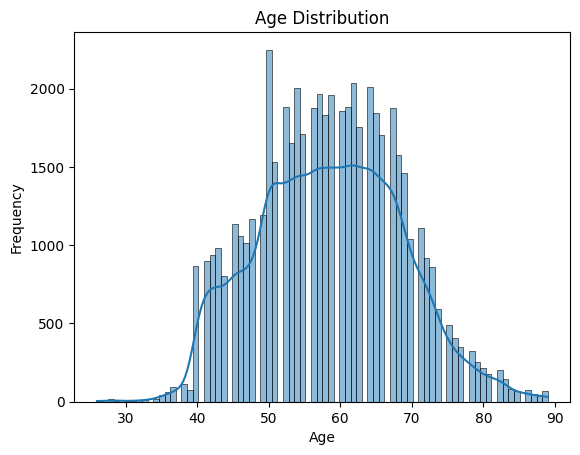

In [13]:
# Example: Plotting distribution of age
sns.histplot(train_metadata['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [14]:
print(train_metadata.shape)

(54706, 14)


In [15]:
print(train_metadata.head())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  


In [16]:
# Crosstab between 'biopsy' and 'cancer'
pd.crosstab(train_metadata['biopsy'], train_metadata['cancer'])

cancer,0,1
biopsy,,
0,51737,0
1,1811,1158


<Axes: xlabel='site_id', ylabel='age'>

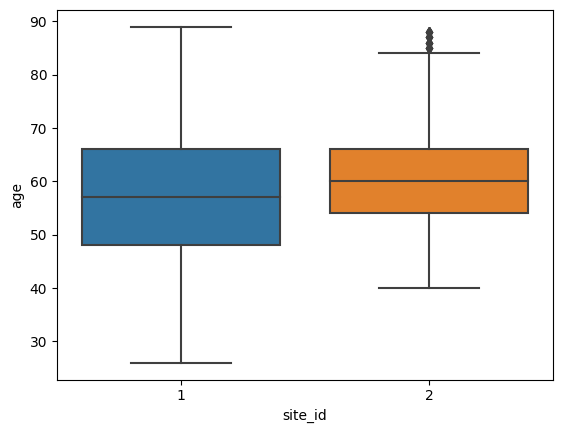

In [17]:
# Boxplot for a feature across different sites
sns.boxplot(x='site_id', y='age', data=train_metadata)

In [18]:
# Checking Missing Data in Training Metadata
missing_data = train_metadata.isnull().sum()
print(missing_data)

site_id                        0
patient_id                     0
image_id                       0
laterality                     0
view                           0
age                           37
cancer                         0
biopsy                         0
invasive                       0
BIRADS                     28420
implant                        0
density                    25236
machine_id                     0
difficult_negative_case        0
dtype: int64


In [19]:
pwd

'/content/drive/MyDrive/RSNA_BreastCancer'

<Axes: >

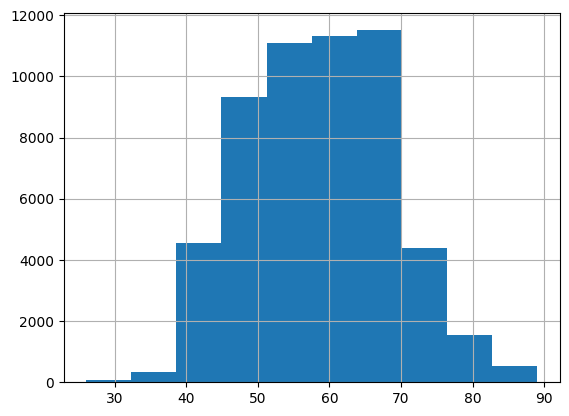

In [20]:
# Age distribution
train_metadata['age'].hist()

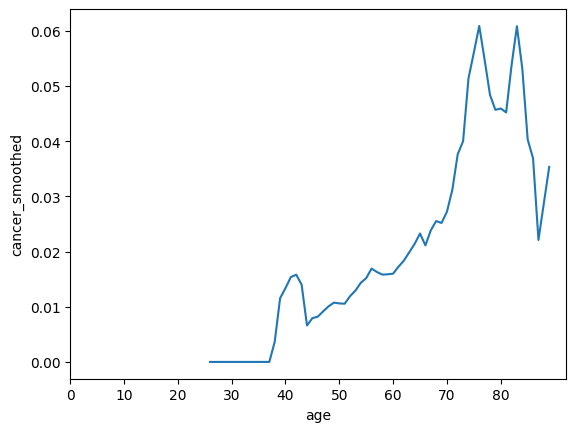

In [21]:
# Age vs. cancer rate, with age labels on x-axis only every 10 years
# Determine cancer rate for each age
age_cancer_rate = train_metadata.groupby('age')['cancer'].mean().reset_index()

# Interpolating missing ages (assuming age is a continuous variable)
age_cancer_rate['cancer_smoothed'] = age_cancer_rate['cancer'].rolling(window=5, min_periods=1).mean()

# Plot with smoothing
sns.lineplot(x='age', y='cancer_smoothed', data=age_cancer_rate)
plt.xticks(np.arange(0, 90, 10))
plt.show()


In [22]:
# Calculate correlation matrix
train_subset=train_metadata[['age','cancer','biopsy','invasive','BIRADS','implant']]
train_subset.corr()

,age,cancer,biopsy,invasive,BIRADS,implant
age,1.000000,0.075155,0.010167,0.068674,0.048258,-0.069599
cancer,0.075155,1.000000,0.613872,0.837815,-0.210718,-0.014311
biopsy,0.010167,0.613872,1.000000,0.514311,-0.410620,-0.002569
invasive,0.068674,0.837815,0.514311,1.000000,-0.172750,-0.008443
BIRADS,0.048258,-0.210718,-0.410620,-0.172750,1.000000,0.025262
implant,-0.069599,-0.014311,-0.002569,-0.008443,0.025262,1.000000


<Axes: >

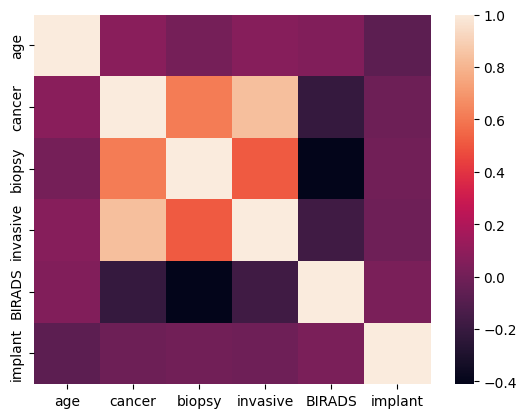

In [23]:
# Create a correlation heatmap
sns.heatmap(train_subset.corr())

In [ ]:
# Image Processing Functions for Breast Region Analysis
import cv2
# Crop image to breast region using bounding box and Otsu thresholding
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return x, y, w, h

# Clip and normalize pixel values in the breast ROI to improve contrast and remove noise
def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized

# Enhance the image using the Contrast Limited Adaptive Histogram Equalization (CLAHE) algorithm
def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [ ]:
#roi_datapath = [data_path+'rsna_annotations/yolo_ds/'+ 'data.yaml']
roi_datapath='rsna_annotations/yolo_ds/'
#example_image_paths = [data_path + 'train_images/' + str(train_metadata.iloc[rand_patient]['patient_id']) + '/' + str(train_metadata.iloc[rand_patient]['image_id']) + '.dcm' for rand_patient in rand_patients]

In [ ]:
#  YOLO Model Training on ROI Data
model = YOLO('yolov8n.pt')
roi_data =data_path + roi_datapath + 'data.yaml'
#roi_data=roi_datapath
results = model.train(data=roi_data, epochs=25)

In [ ]:
# load model
yolo_model = YOLO('runs/detect/train9/weights/best.pt')

In [ ]:
# Inverting DICOM Images
def invert_image_if_white_background(image_to_invert):
    """
    Invert the image.

    :param image_to_invert: A DICOM image as a NumPy array.
    :return: Inverted image.
    """
    return image_to_invert.max() - image_to_invert

In [ ]:
# Isotropic Resizing and Padding of Images
def resize_and_pad_image_isotropically(image, target_size):
    """
    Resize image to the target size, conserving aspect ratio and adding padding if needed.
    :param image: an image to resize
    :param target_size: target size of the image (width, height)
    :return: resized and padded image
    """
    h, w = image.shape[:2]
    # check for zero sized images
    if h == 0 or w == 0:
        print(f"Can't resize image with size 0: {image.shape}")
        raise ValueError(f"Can't resize image with size 0: {image.shape}")
    sh, sw = target_size

    # Interpolation method
    interp = cv2.INTER_AREA if h > sh or w > sw else cv2.INTER_CUBIC

    # Aspect ratio of image
    aspect = w / h

    # Compute new dimensions and scaling factor
    scale_w = sw / w
    scale_h = sh / h
    scale = min(scale_w, scale_h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Calculate padding
    pad_left = (sw - new_w) // 2
    pad_right = sw - new_w - pad_left
    pad_top = (sh - new_h) // 2
    pad_bot = sh - new_h - pad_top

    # Resize the image
    resized_img = cv2.resize(image, (new_w, new_h), interpolation=interp)

    # Add padding
    resized_img = cv2.copyMakeBorder(resized_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return resized_img

In [ ]:
# Converting and Normalizing Images to Float32 type with pixel valuws between [0, 1]
def convert_image_float32_and_normalize(original_image):
    """
    Convert the image to float32 and normalize to [0, 1].
    :param original_image: The image as a NumPy array.
    :return: A normalized image as a NumPy array.
    """
    resized_image = original_image.astype(np.float32) / np.max(original_image)  # Normalize to [0, 1]
    return resized_image

In [ ]:
# Image Transformation Pipeline with PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert numpy array to PyTorch Tensor

])

In [ ]:
# Loading images then Resizing them for YOLO model
def load_and_preprocess_images(image_paths):
    """
    Load DICOM images and apply initial preprocessing.
    """
    images = []
    window_centers = []
    window_widths = []
    inverts = []
    for img_path in image_paths:
        try:
            img, window_center, window_width, invert = load_dicom_image(img_path)
            images.append(img)
            window_centers.append(window_center)
            window_widths.append(window_width)
            inverts.append(invert)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            images.append(None)
            window_centers.append(None)
            window_widths.append(None)
            inverts.append(None)

    return images, window_centers, window_widths, inverts


def resize_image_for_yolo(image, target_size=(640, 640)):
    """
    Resize image maintaining aspect ratio and padding for YOLO model.
    """
    # Resize and pad the image as required by YOLO
    resized_img = resize_and_pad_image_isotropically(image, target_size)
    return resized_img

In [ ]:
# Preprocessing Images for YOLO Model Input
def preprocess_for_yolo(images, inverts):
    """
    Preprocess images for YOLO model input.
    """
    processed_images = []
    for img, invert in zip(images, inverts):
        if img is not None:
            try:
                # Invert image if it has a white background
                img = invert_image_if_white_background(img) if invert else img
                # Resize image to the input size expected by YOLO (e.g., 640x640)
                resized_img = resize_image_for_yolo(img, (640, 640))

                # Convert image to float32 and normalize
                normalized_img = convert_image_float32_and_normalize(resized_img)

                # Convert image to PyTorch tensor and add batch dimension
                tensor_img = transform(normalized_img).unsqueeze(0)

                processed_images.append(tensor_img)
            except Exception as e:
                print(f"Error preprocessing for YOLO: {e}")
                processed_images.append(None)
        else:
            processed_images.append(None)

    # Concatenate all tensor images into a single batch
    batched_tensor = torch.cat([img for img in processed_images if img is not None], dim=0)
    # Convert to rgb
    batched_tensor_rgb = batched_tensor.repeat(1, 3, 1, 1)
    return batched_tensor_rgb

In [ ]:
# Image Cropping and Bounding Box Transformation Functions

def calculate_resized_dimensions(original_size, target_size=(640, 640)):
    """
    Calculate the resized dimensions of an image, for use in transforming bbox to original image size.
    :param original_size: The starting size of the image as a tuple (width, height).
    :param target_size: The target size of the image as a tuple (width, height).
    :return:
    """
    original_width, original_height = original_size
    target_width, target_height = target_size

    # Calculate aspect ratio
    aspect_ratio = original_width / original_height

    # Determine resized dimensions before padding
    if aspect_ratio > 1:  # Landscape orientation
        resized_width = target_width
        resized_height = int(resized_width / aspect_ratio)
    else:  # Portrait orientation or square
        resized_height = target_height
        resized_width = int(resized_height * aspect_ratio)

    return resized_width, resized_height


def convert_bbox_to_original_with_padding(bbox, original_size, padded_size=(640, 640)):
    """
    Convert bounding box coordinates from a resized and padded image to the original image.

    :param bbox: Tuple (xmin, ymin, xmax, ymax) on the resized and padded image.
    :param original_size: Tuple (original_width, original_height) of the image.
    :param padded_size: Final size of the image after padding.
    :return: Adjusted bounding box coordinates as a tuple.
    """
    resized_width, resized_height = calculate_resized_dimensions(original_size, padded_size)
    scale_w = original_size[0] / resized_width
    scale_h = original_size[1] / resized_height

    # Determine padding added during resizing
    pad_w = (padded_size[0] - resized_width) / 2
    pad_h = (padded_size[1] - resized_height) / 2

    # Adjust bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.flatten()
    xmin_original = max((xmin - pad_w) * scale_w, 0)  # Ensure non-negative
    ymin_original = max((ymin - pad_h) * scale_h, 0)  # Ensure non-negative
    xmax_original = min((xmax - pad_w) * scale_w, original_size[0])  # Ensure within original width
    ymax_original = min((ymax - pad_h) * scale_h, original_size[1])  # Ensure within original height

    return xmin_original, ymin_original, xmax_original, ymax_original


def crop_image(uncropped_image, bbox):
    """
    Crop an image to the bounding box coordinates.

    :param uncropped_image: The image as a NumPy array.
    :param bbox: Tuple (xmin, ymin, xmax, ymax) of the bounding box coordinates.
    :return: Cropped image as a NumPy array.
    """
    xmin, ymin, xmax, ymax = bbox
    # if crop would be empty, return original image
    if xmin == xmax or ymin == ymax:
        return uncropped_image
    else:
        return uncropped_image[int(ymin):int(ymax), int(xmin):int(xmax)]


def crop_images_with_yolo(raw_images, yolo_model, inverts):
    """
    Crop images using the YOLO model.
    """
    preprocessed_images = preprocess_for_yolo(raw_images, inverts)
    yolo_results = yolo_model(preprocessed_images, verbose=False)
    cropped_images = []
    for i, result in enumerate(yolo_results):
        if raw_images[i] is not None:
            try:
                bbox = convert_bbox_to_original_with_padding(result.boxes[0].xyxy.cpu().numpy(), (raw_images[i].shape[1], raw_images[i].shape[0]))
                cropped_img = crop_image(raw_images[i], bbox)
                cropped_images.append(cropped_img)
            except Exception as e:
                print(f"Error cropping image: {e}")
                cropped_images.append(None)
        else:
            cropped_images.append(None)
    return cropped_images


In [ ]:
# Image Windowing, Conversion to RGB, and Normalization Functions

def apply_window_single(image_to_window, win_center, win_width):
    """
    Apply windowing to a grayscale image.

    :param image_to_window: The image as a NumPy array.
    :param win_center: The window center.
    :param win_width: The window width.
    :return: The windowed image as a NumPy array.
    """
    # Check that image is numpy array
    assert isinstance(image_to_window, np.ndarray)
    # Handle MultiValue objects
    if isinstance(win_width, pydicom.multival.MultiValue):
        # Choose the first value
        win_width = float(win_width[0])

    if isinstance(win_center, pydicom.multival.MultiValue):
        win_center = float(win_center[0])

    window_min = win_center - (win_width / 2)
    window_max = win_center + (win_width / 2)

    return np.clip(image_to_window, window_min, window_max)


def apply_windowing(images, window_centers_array, window_widths_array):
    """
    Apply windowing to a batch of images.
    """
    images_to_return = []
    for img, window_cnt, window_wid in zip(images, window_centers_array, window_widths_array):
        if img is not None:
            try:
                windowed_img = apply_window_single(img, window_cnt, window_wid)
                images_to_return.append(windowed_img)
            except Exception as e:
                print(f"Error applying windowing: {e}")
                images_to_return.append(None)
        else:
            images_to_return.append(None)
    return images_to_return


def convert_to_rgb_and_normalize(images):
    """
    Convert images to RGB and normalize.
    """
    final_images = []
    for img in images:
        if img is not None and np.max(img) > 0:
            try:
                normalized_img = (img - np.min(img)) / (np.max(img) - np.min(img))
                scaled_img = np.uint8(normalized_img * 255)
                # Convert to RGB and scale to [0, 255]
                rgb_img = np.stack((scaled_img, scaled_img, scaled_img), axis=-1)
                final_images.append(rgb_img)
            except Exception as e:
                print(f"Error converting/normalizing image: {e}")
                final_images.append(None)
        else:
            final_images.append(None)
    return final_images

In [ ]:
# DICOM Image Preprocessing for Training
def preprocess_dicom_images(image_paths, YOLO_model):
    """
    Preprocess DICOM images for training.
    """
    images, window_centers, window_widths, inverts = load_and_preprocess_images(image_paths)
    cropped_images = crop_images_with_yolo(images, YOLO_model, inverts)
    windowed_images = apply_windowing(cropped_images, window_centers, window_widths)
    rgb_images = convert_to_rgb_and_normalize(windowed_images)
    rgb_images = [invert_image_if_white_background(img) if invert else img for img, invert in zip(rgb_images, inverts)]
    final_images = [resize_and_pad_image_isotropically(img, target_size=(2048, 1024)) for img in rgb_images]

    return final_images

In [ ]:
# Batch Preprocessing and Saving of DICOM Images
from tqdm import tqdm
def save_image(image, save_path):
    """
    Save a NumPy array as an image.
    :param image: The image as a NumPy array.
    :param save_path: The path to save the image.
    :return: None
    """
    # Convert to PIL Image
    image = Image.fromarray(image)
    # Save to disk
    image.save(save_path)

def batch_preprocess_and_save(metadata_df, batch_size, YOLO_model, save_dir):
    """
    Preprocess DICOM images for training and save them to disk.
    :param image_paths: Image paths to preprocess.
    :param batch_size: Batch size.
    :param YOLO_model: Pretrained YOLO model.
    :param save_dir: Path to save the preprocessed images.
    :return: Modified metadata DataFrame.
    """
    image_paths = metadata_df['image_path'].values
    num_batches = len(image_paths) // batch_size + int(len(image_paths) % batch_size != 0)
    metadata_df = metadata_df.copy()

    for i in tqdm(range(num_batches), desc='Preprocessing images'):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        batch_paths = image_paths[start_idx:end_idx]

        try:
            batch_images = preprocess_dicom_images(batch_paths, YOLO_model)

            for j, img in enumerate(batch_images):
                save_path = os.path.join(save_dir, f"preprocessed_{start_idx + j}.png")
                metadata_df.at[start_idx + j, 'preprocessed_image_path'] = save_path
                save_image(img, save_path)
        except Exception as e:
            print(f"Error in batch_preprocess_and_save: {e}")
            continue

    return metadata_df

In [ ]:

train_metadata['image_path'] = data_path + 'train_images/' + train_metadata['patient_id'].astype(str) + '/' + train_metadata['image_id'].astype(str) + '.dcm'

In [ ]:
print(train_metadata['image_path'])

In [ ]:
len(train_metadata[train_metadata['cancer'] == 1])
df_cancer = train_metadata[train_metadata['cancer'] == 1]
df_no_cancer = train_metadata[train_metadata['cancer'] == 0]
df_no_cancer_sampled = df_no_cancer.sample(n=(2 * len(df_cancer)))
balanced_data = pd.concat([df_cancer, df_no_cancer_sampled])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)

In [ ]:
print(len(balanced_data))

In [ ]:
save_dir = 'preprocessed_images/'
updated_meta_df = batch_preprocess_and_save(balanced_data, 10, yolo_model, save_dir)

In [ ]:
# Save the cleaned dataframe with no missing data in a csv file path
updated_meta_df_cleaned = updated_meta_df.dropna(subset=['preprocessed_image_path'])
updated_meta_df_cleaned.to_csv(data_path + 'balanced_subset.csv')

In [8]:
updated_meta_df_cleaned = pd.read_csv(data_path + 'balanced_subset.csv')

In [13]:
updated_meta_df_cleaned.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,contrast,image_path,preprocessed_image_path
0,0,2,62470,204846174,R,CC,53.0,0,0,0,NaN,0,NaN,21,False,NaN,train_images/62470/204846174.dcm,preprocessed_images/preprocessed_0.png
1,1,1,33411,1413492927,L,MLO,42.0,0,0,0,2.0,0,C,49,False,NaN,train_images/33411/1413492927.dcm,preprocessed_images/preprocessed_1.png
2,2,1,59102,599539245,R,MLO,46.0,0,0,0,NaN,0,C,49,False,NaN,train_images/59102/599539245.dcm,preprocessed_images/preprocessed_2.png
3,3,1,19781,1627243602,L,MLO,51.0,0,0,0,1.0,0,C,49,False,NaN,train_images/19781/1627243602.dcm,preprocessed_images/preprocessed_3.png
4,4,2,54671,1214090918,L,CC,71.0,1,1,1,NaN,0,NaN,29,False,NaN,train_images/54671/1214090918.dcm,preprocessed_images/preprocessed_4.png


In [9]:
updated_meta_df_cleaned['preprocessed_image_path']=updated_meta_df_cleaned['preprocessed_image_path'].str.replace('preprocessed_images', '/content/drive/MyDrive/RSNA_BreastCancer/preprocessed_images')

In [12]:
print(np.sum(updated_meta_df_cleaned['cancer']==1))
print(np.sum(updated_meta_df_cleaned['cancer']==0))

1154
2310


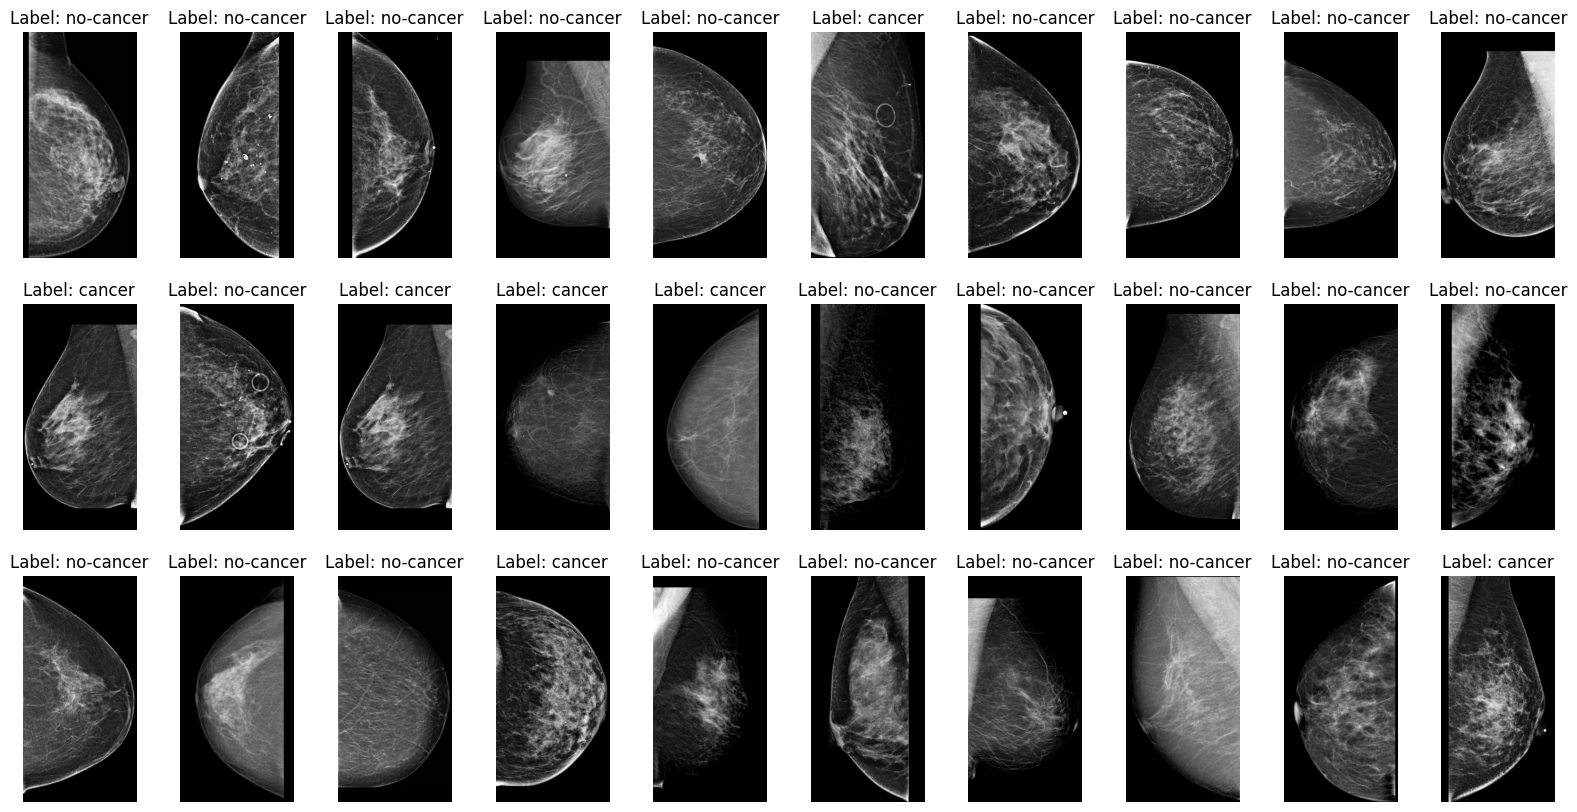

In [12]:
# Plot a few random preprocessed images
rand_patients = np.random.randint(0, len(updated_meta_df_cleaned), 30)
example_image_paths = [updated_meta_df_cleaned.iloc[rand_patient]['preprocessed_image_path'] for rand_patient in rand_patients]

plt.figure(figsize=(20, 10))
labels = ['no-cancer', 'cancer']
for i, image in enumerate(example_image_paths):
    if os.path.exists(image):
        image = Image.open(image)
        plt.subplot(3, 10, i + 1)
        plt.imshow(image, cmap='bone')
        plt.axis('off')
        plt.title('Label: ' + labels[updated_meta_df_cleaned.iloc[rand_patients[i]]['cancer']])
    else:
        print(image)
        print('Image not found!')

plt.show()

In [10]:
# ConvNext Model
def create_convnext_model(model_name, num_classes, in_chans=3, global_pool='avg'):
    """
    Create a ConvNext model.
    :param model_name: name of the model
    :param num_classes: number of classes
    :param in_chans: number of input channels
    :param global_pool: type of global pooling
    :return: ConvNext model
    """
    convnext_model = create_model(
        model_name,
        pretrained=True,
        num_classes=num_classes,
        in_chans=in_chans,
        global_pool=global_pool,
    )
    return convnext_model

In [11]:
# Vision Transformer Model (vit)
def create_vit_model(model_name, num_classes, in_chans=3, global_pool='avg'):
    """
    Create a vit model.
    :param model_name: name of the model
    :param num_classes: number of classes
    :param in_chans: number of input channels
    :param global_pool: type of global pooling
    :return: vit model
    """
    vit_model = create_model(
        model_name,
        pretrained=True,
        num_classes=num_classes,
        in_chans=in_chans,
        global_pool=global_pool,
    )
    return vit_model

In [13]:
# Vision Transformer (ViT) Models from timm library
all_vit_models = timm.list_models('*vit*')
all_vit_models

['convit_base',
 'convit_small',
 'convit_tiny',
 'crossvit_9_240',
 'crossvit_9_dagger_240',
 'crossvit_15_240',
 'crossvit_15_dagger_240',
 'crossvit_15_dagger_408',
 'crossvit_18_240',
 'crossvit_18_dagger_240',
 'crossvit_18_dagger_408',
 'crossvit_base_240',
 'crossvit_small_240',
 'crossvit_tiny_240',
 'davit_base',
 'davit_giant',
 'davit_huge',
 'davit_large',
 'davit_small',
 'davit_tiny',
 'efficientvit_b0',
 'efficientvit_b1',
 'efficientvit_b2',
 'efficientvit_b3',
 'efficientvit_l1',
 'efficientvit_l2',
 'efficientvit_l3',
 'efficientvit_m0',
 'efficientvit_m1',
 'efficientvit_m2',
 'efficientvit_m3',
 'efficientvit_m4',
 'efficientvit_m5',
 'fastvit_ma36',
 'fastvit_s12',
 'fastvit_sa12',
 'fastvit_sa24',
 'fastvit_sa36',
 'fastvit_t8',
 'fastvit_t12',
 'flexivit_base',
 'flexivit_large',
 'flexivit_small',
 'gcvit_base',
 'gcvit_small',
 'gcvit_tiny',
 'gcvit_xtiny',
 'gcvit_xxtiny',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_256d',
 'levit_384',
 '

In [12]:
# Create a Dataset object, with the image paths, plus the target from the new metadata df
class ImageDataset(Dataset):
    def __init__(self, metadata_df, transform=None):
        self.image_paths = metadata_df['preprocessed_image_path'].values
        self.targets = metadata_df['cancer'].values
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        # get the target
        target = self.targets[idx]
        # apply the transform
        if self.transform:
            image = self.transform(image)
        return image, target

In [13]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(updated_meta_df_cleaned, test_size=0.2, random_state=42)

In [17]:
print(len(train_df))

2771


In [14]:
# Create random split of data into train and val
train_dataset = ImageDataset(train_df)
# Create a Dataset object using small subset of the data
val_dataset = ImageDataset(val_df)

In [22]:
# Data Resolution
print(len(train_dataset))
temp=train_dataset[1]
temp=temp[0]
print(temp.size())


2771
torch.Size([3, 2048, 1024])


In [15]:
# Data Loader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [25]:
print(len(train_dataloader))

693


In [16]:
def calculate_accuracy(outputs, targets, threshold=0.5):
    """
    Calculate the accuracy of the model's predictions.
    :param outputs: Model outputs.
    :param targets: True labels.
    :param threshold: Threshold for the predictions.
    :return: Accuracy.
    """
    # Apply sigmoid to the outputs to get predictions
    predictions = torch.sigmoid(outputs) > threshold
    # Calculate accuracy
    correct = (predictions == targets.unsqueeze(1)).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [17]:
# Calculate Metrics and Plot them
def calculate_metrics(outputs, targets, thresholds=np.linspace(-1,1,20)):
    """
    Calculate accuracy, precision, recall, and F1 score of the model's predictions at different thresholds
    and find the best threshold.
    :param outputs: Model outputs.
    :param targets: True labels.
    :param thresholds: Range of thresholds to evaluate.
    :return: Best threshold and dictionary with accuracy, precision, recall, and F1 score for this threshold.
    """
    best_threshold = None
    best_metric = 0
    sigmoid_outputs = torch.sigmoid(outputs)
    precision_all=[]
    recall_all=[]
    F1_all=[]
    accuracy_all=[]

    # Check if targets need to be unsqueezed
    if targets.dim() == 1:
        targets = targets.unsqueeze(1)

    for threshold in thresholds:
        predictions = (sigmoid_outputs > threshold).float()

        TP = ((predictions == 1) & (targets == 1)).float().sum()
        FP = ((predictions == 1) & (targets == 0)).float().sum()
        TN = ((predictions == 0) & (targets == 0)).float().sum()
        FN = ((predictions == 0) & (targets == 1)).float().sum()

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / (TP + FP +TN +FN)
        precision_all.append(precision)
        recall_all.append(recall)
        F1_all.append(F1)
        accuracy_all.append(accuracy)


        if F1 > best_metric:
            best_metric = F1
            best_threshold = threshold

    best_predictions = (sigmoid_outputs > best_threshold).float()
    TP = ((best_predictions == 1) & (targets == 1)).float().sum()
    FP = ((best_predictions == 1) & (targets == 0)).float().sum()
    TN = ((best_predictions == 0) & (targets == 0)).float().sum()
    FN = ((best_predictions == 0) & (targets == 1)).float().sum()

    best_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    best_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    best_F1 = 2 * best_precision * best_recall / (best_precision + best_recall) if (best_precision + best_recall) > 0 else 0
    best_accuracy = (TP + TN) / (TP + FP + TN + FN)
    auc_roc = roc_auc_score(targets.cpu().detach().numpy(), sigmoid_outputs.cpu().detach().numpy())
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.subplot(4, 1,1)
    plt.plot(thresholds,accuracy_all)
    plt.ylabel('Accuracy')
    plt.xlabel('Threshold')
    plt.subplot(4, 1,2)
    plt.plot(thresholds,precision_all)
    plt.ylabel('Precision')
    plt.xlabel('Threshold')
    plt.subplot(4, 1,3)
    plt.plot(thresholds,recall_all)
    plt.ylabel('Recall')
    plt.xlabel('Threshold')
    plt.subplot(4, 1,4)
    plt.plot(thresholds,F1_all)
    plt.ylabel('F1')
    plt.xlabel('Threshold')
    plt.show()

    return  {'accuracy': best_accuracy.item(), 'precision': best_precision.item(), 'recall': best_recall.item(), 'F1': best_F1.item(), 'AUC ROC': auc_roc}


In [18]:
def pfbeta_torch(labels, predictions, beta=1.0):
    """
    Compute the probabilistic F1 score (pFbeta) using PyTorch tensors.
    :param labels: Tensor of true labels (0 or 1).
    :param predictions: Tensor of model output probabilities.
    :param beta: Beta value for F-beta score. Default is 1.0 (F1 score).
    :return: Probabilistic F-beta score.
    """
    # Ensure labels and predictions are float tensors
    labels = labels.float()
    predictions = predictions.float()

    # Clamp predictions between 0 and 1
    predictions = torch.clamp(predictions, min=0, max=1)

    # Compute components of the probabilistic F-beta score
    beta_squared = beta ** 2
    ctp = torch.sum(predictions * labels)  # True positive contributions
    cfp = torch.sum(predictions * (1 - labels))  # False positive contributions
    y_true_count = labels.sum()  # Total number of true positives

    # Calculate precision and recall
    c_precision = ctp / (ctp + cfp) if (ctp + cfp) > 0 else torch.tensor(0.0)
    c_recall = ctp / y_true_count if y_true_count > 0 else torch.tensor(0.0)

    # Calculate pFbeta score
    if c_precision > 0 and c_recall > 0:
        pfbeta_score = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
    else:
        pfbeta_score = torch.tensor(0.0)

    return pfbeta_score.item()

In [19]:
# A Loop to Train the Model, Evaluate it on the validation, and Implement early stopping based on the validation loss to prevent overfitting
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import numpy as np



def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, scheduler, device, epochs=1, grad_accum_steps=1):
    avg_train_loss = 0
    avg_val_loss = 0
    best_val_loss=1000
    counter=0
    patience=2
    for epoch in range(1):
        model.train()
        train_loss = 0
        accum_iter = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1).float()) / grad_accum_steps
            loss.backward()

            if (accum_iter + 1) % grad_accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            accum_iter += 1
            train_loss += loss.item()
      #      print(f'\rEpoch: {epoch + 1}, Batch {batch_idx + 1}/{len(train_loader)} - Loss: {loss.item():.6f}', end='')
            print(f'\rEpoch: {epoch + 1}, Batch {batch_idx + 1} - Loss: {loss.item():.6f}', end='')
            if batch_idx==30:
                break

        avg_train_loss = train_loss / len(train_loader)

        # Evaluation loop
        model.eval()
        val_loss = 0
        total_accuracy = 0
        total_f1 = 0
        all_preds = []
        all_targets = []


        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # Reset the counter
            best_epoch = epoch
            # Save the best model (optional)

        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1} as validation loss did not improve for {patience} epochs.')
                break  # Stop training
        scheduler.step(epoch)

    return avg_train_loss, avg_val_loss


In [20]:
import torch.nn as nn

In [21]:
# ConvNext Model Architecture
model_info = {
    'model_name': 'convnext_small.fb_in22k_ft_in1k_384',
    'num_classes': 1,
    'in_chans': 3,
    'global_pool': 'max',
}

In [40]:
# Initializing ConvNext Model
conv_model = create_convnext_model(**model_info)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    conv_model = nn.DataParallel(conv_model)
#device='cpu'

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

In [25]:
# Initializing Optimizer, Loss, and Scheduler
from timm.loss import BinaryCrossEntropy
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
optimizer = create_optimizer_v2(conv_model, opt='sgd', lr=3e-4, weight_decay=1e-5, momentum=0.9)
criterion = BinaryCrossEntropy(smoothing=0.1, target_threshold=0.5)
scheduler, num_epochs = create_scheduler_v2(optimizer, sched='cosine', num_epochs=3, decay_epochs=4, cooldown_epochs=1, warmup_epochs=4, min_lr=5e-5)

In [26]:
train_loss, val_loss = train_and_evaluate(conv_model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device, epochs=num_epochs, grad_accum_steps=4)

Epoch: 1, Batch 31 - Loss: 0.209307

In [27]:
# Validation Predictions
predictions = []
targets = []
counter=0
with torch.no_grad():
    for data, target in val_dataloader:
        #print(counter)
        data, target = data.to(device), target.to(device)
        output = conv_model(data)
        predictions.extend(output.cpu().numpy())
        targets.extend(target.cpu().numpy())
        counter=counter+1
        if counter==10:
          break


# Convert predictions and targets to tensors
predictions = torch.tensor(predictions)
targets = torch.tensor(targets)

<ipython-input-27-3b78373d3cf5>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  predictions = torch.tensor(predictions)


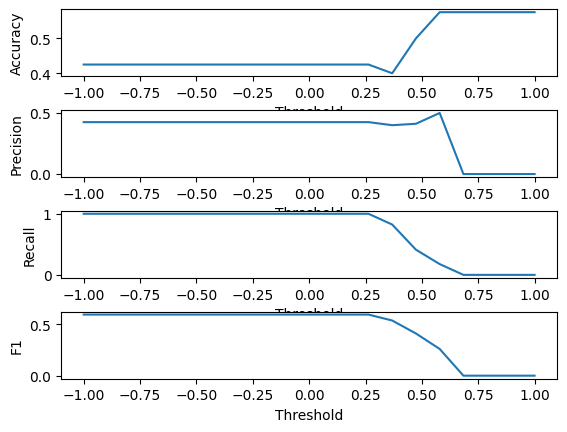

{'accuracy': 0.42500001192092896,
 'precision': 0.42500001192092896,
 'recall': 1.0,
 'F1': 0.596491277217865,
 'AUC ROC': 0.5140664961636828}

In [28]:
calculate_metrics(predictions, targets)

In [41]:

# Hyperparameter Tuning
# change the optimizer to adam instead of sgd
# will change lr to 1e-4 instead of 3e-4, and thw weight decay to 1e-4 instead of 1e-5
#change the momentum from 0.9 to 0.95, the decay epochs from 10 to 8
# the cooldown_epochs from 1 to 2, the warmup_epochs from 4 to 3
from timm.loss import BinaryCrossEntropy
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
optimizer = create_optimizer_v2(conv_model, opt='adam', lr=1e-4, weight_decay=1e-4, momentum=0.95)
criterion = BinaryCrossEntropy(smoothing=0.1, target_threshold=0.5)
scheduler, num_epochs = create_scheduler_v2(optimizer, sched='cosine', num_epochs=1, decay_epochs=8, cooldown_epochs=2, warmup_epochs=3, min_lr=5e-5)

In [42]:
train_loss, val_loss = train_and_evaluate(conv_model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device, epochs=num_epochs, grad_accum_steps=4)

Epoch: 1, Batch 31 - Loss: 0.204549

In [43]:
# Validation Predictions
predictions = []
targets = []
counter=0
with torch.no_grad():
    for data, target in val_dataloader:
        #print(counter)
        data, target = data.to(device), target.to(device)
        output = conv_model(data)
        predictions.extend(output.cpu().numpy())
        targets.extend(target.cpu().numpy())
        counter=counter+1
        if counter==10:
          break


# Convert predictions and targets to tensors
predictions = torch.tensor(predictions)
targets = torch.tensor(targets)

<ipython-input-43-3b78373d3cf5>:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  predictions = torch.tensor(predictions)


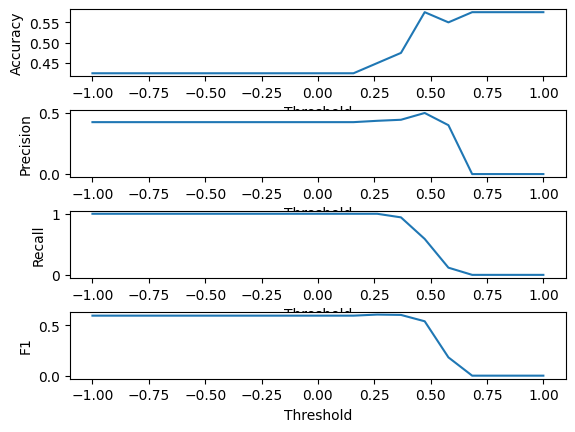

{'accuracy': 0.44999998807907104,
 'precision': 0.43589743971824646,
 'recall': 1.0,
 'F1': 0.6071428656578064,
 'AUC ROC': 0.5447570332480818}

In [44]:
calculate_metrics(predictions, targets)

In [22]:
# VIT Model Architecture
model_info_vit = {
    'model_name':  'maxvit_nano_rw_256',
    'num_classes': 1,
    'in_chans': 3,
    #'global_pool': 'max',
}

#

In [31]:
# Initializing VIT Nano Model
vit_model = create_vit_model(**model_info_vit)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cpu'
vit_model.to(device)

#if torch.cuda.device_count() > 1:
 #   print(f"Using {torch.cuda.device_count()} GPUs!")
  #  vit_model = nn.DataParallel(vit_model)

MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MaxxVitBlock(
          (conv): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
            (down): Identity()
            (conv1_1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm1

In [32]:
# Initializing Optimizer, Loss, and Scheduler
from timm.loss import BinaryCrossEntropy
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
optimizer_vit = create_optimizer_v2(vit_model, opt='sgd', lr=3e-4, weight_decay=1e-5, momentum=0.9)
criterion = BinaryCrossEntropy(smoothing=0.1, target_threshold=0.5)
scheduler_vit, num_epochs = create_scheduler_v2(optimizer_vit, sched='cosine', num_epochs=1, decay_epochs=10, cooldown_epochs=1, warmup_epochs=4, min_lr=5e-5)

In [33]:
train_loss_vit, val_loss_vit = train_and_evaluate(vit_model, train_dataloader, val_dataloader, optimizer_vit, criterion, scheduler_vit, device, epochs=num_epochs, grad_accum_steps=4)

Epoch: 1, Batch 31 - Loss: 0.169316

In [36]:
# Validation Predictions
predictions = []
targets = []
counter=0
with torch.no_grad():
    for data, target in val_dataloader:
        #print(counter)
        data, target = data.to(device), target.to(device)
        output = vit_model(data)
        predictions.extend(output.cpu().numpy())
        targets.extend(target.cpu().numpy())
        counter=counter+1
        if counter==10:
          break

# Convert predictions and targets to tensors
predictions = torch.tensor(predictions)
targets = torch.tensor(targets)


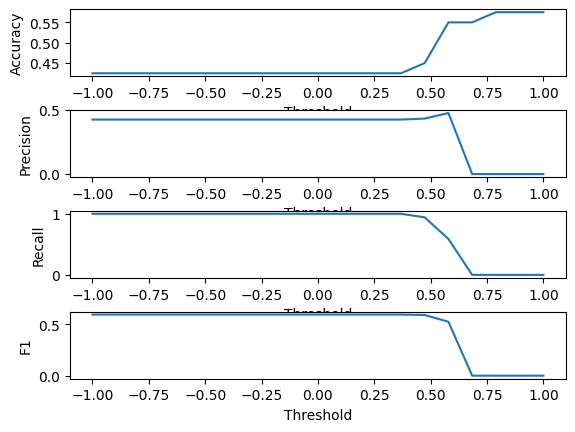

{'accuracy': 0.42500001192092896,
 'precision': 0.42500001192092896,
 'recall': 1.0,
 'F1': 0.596491277217865,
 'AUC ROC': 0.5728900255754475}

In [37]:
calculate_metrics(predictions, targets)

In [27]:
# we train a Vit (Vision Transformer) nano model
vit_model = create_vit_model(**model_info_vit)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cpu'
vit_model.to(device)

#if torch.cuda.device_count() > 1:
 #   print(f"Using {torch.cuda.device_count()} GPUs!")
  #  vit_model = nn.DataParallel(vit_model)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/61.9M [00:00<?, ?B/s]

MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MaxxVitBlock(
          (conv): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
            (down): Identity()
            (conv1_1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm1

In [28]:
# Hyperparameter Tuning
# change the optimizer to adam instead of sgd
# will change lr to 1e-4 instead of 3e-4, and thw weight decay to 1e-4 instead of 1e-5
#change the momentum from 0.9 to 0.95, the decay epochs from 10 to 8
# the cooldown_epochs from 1 to 2, the warmup_epochs from 4 to 3
from timm.loss import BinaryCrossEntropy
from timm.optim import create_optimizer_v2
from timm.scheduler import create_scheduler_v2
optimizer_vit = create_optimizer_v2(vit_model, opt='adam', lr=1e-4, weight_decay=1e-4, momentum=0.95)
criterion = BinaryCrossEntropy(smoothing=0.1, target_threshold=0.5)
scheduler_vit, num_epochs = create_scheduler_v2(optimizer_vit, sched='cosine', num_epochs=1, decay_epochs=8, cooldown_epochs=2, warmup_epochs=3, min_lr=5e-5)

In [40]:
train_loss_vit, val_loss_vit = train_and_evaluate(vit_model, train_dataloader, val_dataloader, optimizer_vit, criterion, scheduler_vit, device, epochs=num_epochs, grad_accum_steps=4)

Epoch: 1, Batch 31 - Loss: 0.163097

In [41]:
# Validation Predictions
predictions = []
targets = []
counter=0
with torch.no_grad():
    for data, target in val_dataloader:
        #print(counter)
        data, target = data.to(device), target.to(device)
        output = vit_model(data)
        predictions.extend(output.cpu().numpy())
        targets.extend(target.cpu().numpy())
        counter=counter+1
        if counter==10:
          break
# Convert predictions and targets to tensors
predictions = torch.tensor(predictions)
targets = torch.tensor(targets)

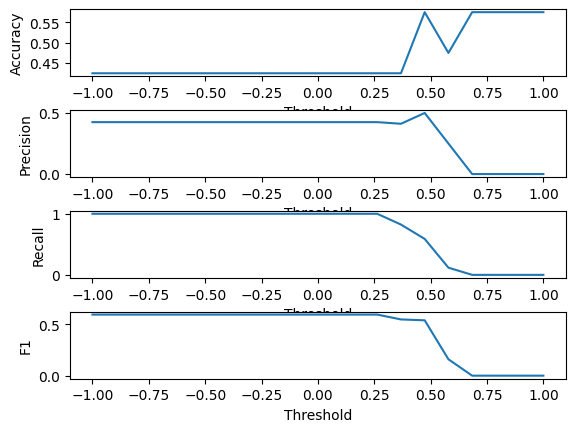

{'accuracy': 0.42500001192092896,
 'precision': 0.42500001192092896,
 'recall': 1.0,
 'F1': 0.596491277217865,
 'AUC ROC': 0.5242966751918159}

In [42]:
calculate_metrics(predictions, targets)